In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="darkgrid")
from scipy.stats import ttest_ind, normaltest, mannwhitneyu
import warnings
warnings.filterwarnings("ignore")

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv('/content/drive/MyDrive/mvideo HA/М.Тех_Данные_к_ТЗ_DS.csv', sep='\,', engine='python', header=None, encoding='cp1251').apply(lambda x: x.str.replace(r"\"","", regex=True))
rename_columns = {0: df[0][0], 1: df[1][0], 2: df[2][0]}
df.rename(rename_columns, axis=1, inplace=True)
df.drop(0, axis=0, inplace=True)
df = df.astype({'Количество больничных дней': 'int32', 'Возраст': 'int32'})
#некоторые манипуляции с считыванием csv-ки
df.head()

,Количество больничных дней,Возраст,Пол
1,5,39,Ж
2,4,54,М
3,4,26,М
4,5,42,М
5,4,29,М


In [29]:
#посмотрим на число пропущенных значений
df.isnull().sum()

Количество больничных дней    0
Возраст                       0
Пол                           0
dtype: int64

# Тестовое задание:

Руководство компании обратило внимание на то, что сотрудники старше 35
лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин
количество пропусков рабочих дней в связи с больничным выше, чем среди женщин.
В связи с этой ситуацией, руководство организации планирует ввести
дополнительные медицинские осмотры среди групп риска.
Вам необходимо проверить следующие гипотезы:

1. Мужчины пропускают в течение года более 2 рабочих дней (work_days) по
болезни значимо чаще женщин

2. Работники старше 35 лет (age) пропускают в течение года более 2 рабочих
дней (work_days) по болезни значимо чаще своих более молодых коллег

# 1 Гипотеза

Начнем с тестирования первой гипотезы.

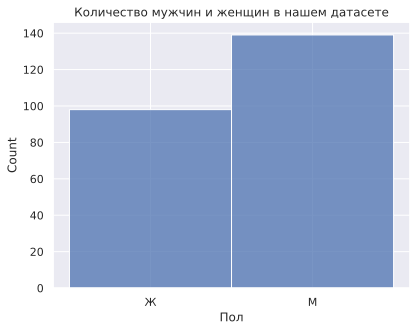

In [30]:
#посмотрим на распределение мужчин и женщин в нашем датасете
sns.histplot(data=df, x="Пол", bins=10)
plt.title('Количество мужчин и женщин в нашем датасете');

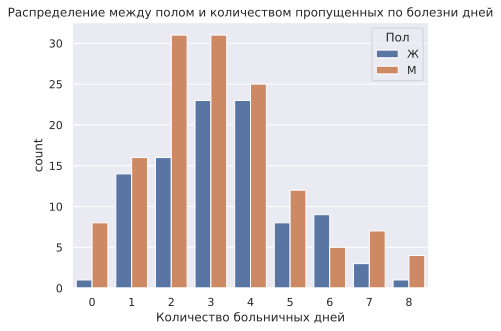

In [31]:
#также посмотрим на распределение мужчин и женщин по количествам пропущенных дней
sns.countplot(df, x="Количество больничных дней", hue="Пол").set(title='Распределение между полом и количеством пропущенных по болезни дней');

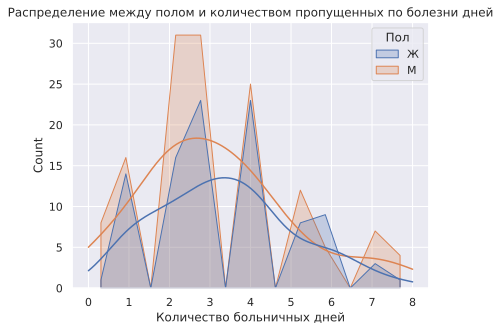

In [32]:
sns.histplot(data=df, x="Количество больничных дней", hue="Пол", element="poly", kde=True).set(title='Распределение между полом и количеством пропущенных по болезни дней');

Давайте в первую очередь протестируем как соотносится среднее количество больничных дней для мужчин и женщин, при этом нам интересны люди, пропускающие более 2 дней (work_days), поэтому выделим подвыборку и проведем t-test.



$$
H_0: \mu_{women} \ge \mu_{men} \\ \text{(в среднем женщины пропускают больше или столько же рабочих дней, сколько и мужчины)}
$$

$$
\text{versus}
$$

$$
H_1: \mu_{women} < \mu_{men} \\ \text{(в среднем мужчины пропускают больше рабочих дней чем женщины)}
$$


---


Для того, чтобы проводить t-test мы должны быть уверены, что данные имеют распределение близкое к нормальному или же у нас много сэмплов, поэтому давайте также проведем тест на нормальность:

$$
H_0: \text{Подвыборка имеет нормальное распределение}
$$

$$
\text{versus}
$$

$$
H_1: \text{Подвыборка имеет распределение отличное от нормального}
$$



---

Ниже реализован класс, который на вход принимает датафрейм, уровень значимости $\alpha$, количество пропущенных рабочих дней. Он проводит тест на нормальность и, в зависимости от нормальности распределения и размера нашей выборки, выдает результаты t-теста или же непараметрического теста Манна-Уитни


In [33]:
class mean_test_between_men_and_women:

    def __init__(self, df, alpha=0.05, work_days=2):
        # :df: input [DataFrame]
        # :alpha: statistical significance level [int]
        # :work_days: number of missed working days we want to explore [int]
        self.df = df
        self.alpha = alpha
        self.work_days = work_days

    def df_cutting(self):

        #нам интересно число пропущенных дней > work_days
        df_cut = self.df[self.df['Количество больничных дней'] > self.work_days]

        #создадим две подвыборки с пропущенными дням, соответствующие мужчинам и женщинам
        men = df_cut[df_cut['Пол'] == 'М']['Количество больничных дней'].values
        women = df_cut[df_cut['Пол'] == 'Ж']['Количество больничных дней'].values

        return men, women

    def t_test(self, men, women):
        #t-test, мы можем считать наши распределения независимыми, поэтому используем ttest_ind из scipy библотеки
        stat, p = ttest_ind(men, women, alternative='greater') #alternative='greater' означает, что согласно альтернативной гипотезы 𝜇_men > 𝜇_women
        if p <= self.alpha:
            print(f'T-test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men отвергается, т.к. p-value для t-test {round(p, 3)} < {self.alpha} - уровня значимости')
            print('\nМы принимаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин\n')
        else:
            print(f'T-test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men не может быть отвергнута, т.к. p-value для t-test {round(p, 3)} > {self.alpha} - уровня значимости')
            print('\nМы отвергаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин\n')

    def mannwhitneyu_test(self, men, women):
        #Mann-Whitney U test:
        stat, p = mannwhitneyu(men, women, alternative='greater') #alternative='greater' означает, что согласно альтернативной гипотезы 𝜇_men > 𝜇_women
        if p <= self.alpha:
            print(f'Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men отвергается, т.к. p-value для Mann-Whitney U test {round(p, 3)} < {self.alpha} - уровня значимости')
            print('\nМы принимаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин\n')
        else:
            print(f'Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men не может быть отвергнута, т.к. p-value для Mann-Whitney U test {round(p, 3)} > {self.alpha} - уровня значимости')
            print('\nМы отвергаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин\n')

    def test(self):
         #тест на нормальность
         men, women = self.df_cutting()
         if len(men) < 8 or len(women) < 8:
            print('Невозможно провести тесты, так как размеры подвыборки малы: n<8, добавьте данных в датасет или же уменьшите параметр work_days')
            return
         stat_norm_men, p_norm_men = normaltest(men)
         stat_norm_women, p_norm_women = normaltest(women)
         #также проверяем размер наших подвыборок, в случае больших подвыборок - мы можем проводить t-test
         if (p_norm_men <= self.alpha or p_norm_women <= self.alpha) and (len(men) < 40 or len(women) < 40):
             print(f'Мы не можем провести t-test так как мы не можем принять гипотезу о нормальности распределенных данных или же у нас маленький датасет, результаты теста на нормальность: \nдля мужчин p-value = {round(p_norm_men, 3)} \nдля женщин p-value = {round(p_norm_women, 3)} \nна уровне значимости alpha = {self.alpha}')
             print('\nНо можем провести непараметрический тест Манна — Уитни:')
             self.mannwhitneyu_test(men, women)
         else:
             self.t_test(men, women), self.mannwhitneyu_test(men, women)
         return


In [34]:
testing1 = mean_test_between_men_and_women(df)

In [35]:
testing1.test()

T-test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men не может быть отвергнута, т.к. p-value для t-test 0.339 > 0.05 - уровня значимости

Мы отвергаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин

Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_women ≥ 𝜇_men не может быть отвергнута, т.к. p-value для Mann-Whitney U test 0.477 > 0.05 - уровня значимости

Мы отвергаем гипотезу о том, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин



Таким образом, мы ошибемся с вероятностью 34%, отвергнув нулевую гипотезу о том, что в среднем женщины пропускают работу по болезни не реже мужчин.


---

Также можем поссчитать сколько в среднем рабочих дней пропускают мужчины и женщины при помощи бутстрепа, построив доверительные интервалы.

Считаем, что наше распределение близко к нормальному, тогда MLE estimation для среднего это просто: $\mu = \frac{1}{n}\sum_{i=1}^n{x_i}$. Насэмплим k подвыборок и построим доверительные интервалы.


In [36]:
class bootstrap_for_men_and_women():

    def __init__(self, df, k=10000, alpha=0.05):
        # :df: input [DataFrame]
        # :k: number of subsamples [int]
        # :alpha: statistical significance level [int]
        self.df = df
        self.k = k
        self.alpha = alpha

    def men_and_women(self):
        #создадим две подвыборки, соответствующие мужчинам и женщинам
        men = self.df[self.df['Пол'] == 'М']['Количество больничных дней'].values
        women = self.df[self.df['Пол'] == 'Ж']['Количество больничных дней'].values

        return men, women

    def sampling(self, data):
        #генерим выборки для бутстрепа
        index = np.random.randint(0, len(data), (self.k, len(data)))
        samples = data[index]

        return samples

    def conf_intervals(self, mean):
        # функция для интервальной оценки
        # :mean: list of mean values for our subsamples [list]
        boundaries = np.percentile(mean, [100 * self.alpha / 2., 100 * (1 - self.alpha / 2.)])

        return boundaries

    def generation(self):
        men, women = self.men_and_women()
        men_means = [np.mean(sample) for sample in self.sampling(men)]
        women_means = [np.mean(sample) for sample in self.sampling(women)]

        return men_means, women_means

    def intervals(self):
        men_means, women_means = self.generation()
        conf_int_men = self.conf_intervals(men_means)
        conf_int_women = self.conf_intervals(women_means)
        print(f'С {int(100*(1-self.alpha))}% вероятностью мужчина пропускает кол-во рабочих дней в диапазоне от {round(conf_int_men[0], 2)} до {round(conf_int_men[1], 2)}')
        print(f'С {int(100*(1-self.alpha))}% вероятностью женщина пропускает кол-во рабочих дней в диапазоне от {round(conf_int_women[0], 2)} до {round(conf_int_women[1], 2)}')

In [37]:
bootstrap1 = bootstrap_for_men_and_women(df)

In [38]:
bootstrap1.intervals()

С 95% вероятностью мужчина пропускает кол-во рабочих дней в диапазоне от 2.87 до 3.5
С 95% вероятностью женщина пропускает кол-во рабочих дней в диапазоне от 3.04 до 3.7


# 2 Гипотеза

Перейдем к тестированию второй гипотезы. (Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег)

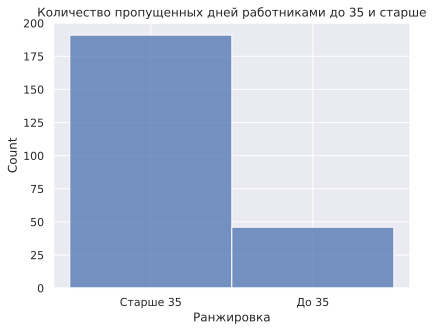

In [39]:
#посмотрим на распределение молодых работников и работников старше 35 в нашем датасете
df['Ранжировка'] = df['Возраст']
df['Ранжировка'] = df['Ранжировка'].map(lambda x: 'До 35' if x < 35 else 'Старше 35')
sns.histplot(data=df, x="Ранжировка")
plt.title('Количество пропущенных дней работниками до 35 и старше');

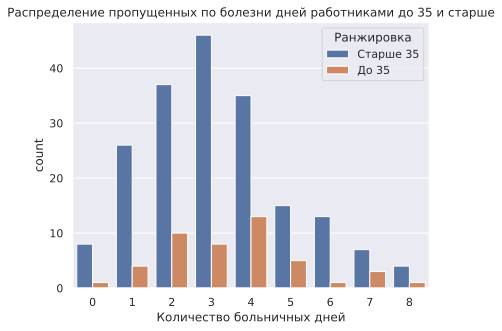

In [40]:
#также посмотрим на распределение по количествам пропущенных дней
sns.countplot(df, x="Количество больничных дней", hue="Ранжировка").set(title='Распределение пропущенных по болезни дней работниками до 35 и старше');

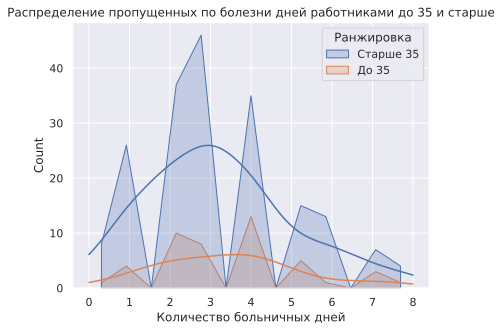

In [41]:
sns.histplot(data=df, x="Количество больничных дней", hue="Ранжировка", element="poly", kde=True).set(title='Распределение пропущенных по болезни дней работниками до 35 и старше');

Построим исследование схожим с проверкой 1 гипотезы образом.

Давайте в первую очередь протестируем как соотносится среднее количество больничных дней для работников младше 35 и старше, при этом нам интересны люди, пропускающие более 2 дней (work_days), поэтому выделим подвыборки и проведем t-test.



$$
H_0: \mu_{young} \ge \mu_{aged} \\ \text{(в среднем молодые работники пропускают столько же рабочих дней, сколько и взрослые)}
$$

$$
\text{versus}
$$

$$
H_1: \mu_{young} < \mu_{aged} \\ \text{(в среднем взрослые пропускают больше рабочих дней чем молодые)}
$$


---


Для того, чтобы проводить t-test мы должны быть уверены, что данные имеют распределение близкое к нормальному или же у нас много сэмплов, поэтому давайте также проведем тест на нормальность:

$$
H_0: \text{Подвыборка имеет нормальное распределение}
$$

$$
\text{versus}
$$

$$
H_1: \text{Подвыборка имеет распределение отличное от нормального}
$$



---

Ниже реализован класс, который на вход принимает датафрейм, уровень значимости $\alpha$, количество пропущенных рабочих дней. Он проводит тест на нормальность и, в зависимости от нормальности распределения и размера нашей выборки, выдает результаты t-теста или же непараметрического теста Манна-Уитни


In [42]:
class mean_test_between_young_and_aged:

    def __init__(self, df, alpha=0.05, work_days=2):
        # :df: input [DataFrame]
        # :alpha: statistical significance level [int]
        # :work_days: number of missed working days we want to explore [int]
        self.df = df
        self.alpha = alpha
        self.work_days = work_days

    def df_cutting(self):

        #нам интересно число пропущенных дней > work_days
        df_cut = self.df[self.df['Количество больничных дней'] > self.work_days]

        #создадим две подвыборки с пропущенными дням, соответствующие мужчинам и женщинам
        aged = df_cut[df_cut['Ранжировка'] == 'До 35']['Количество больничных дней'].values
        young = df_cut[df_cut['Ранжировка'] == 'Старше 35']['Количество больничных дней'].values

        return aged, young

    def t_test(self, aged, young):
        #t-test, мы можем считать наши распределения независимыми, поэтому используем ttest_ind из scipy библотеки
        stat, p = ttest_ind(aged, young, alternative='greater') #alternative='greater' означает, что согласно альтернативной гипотезы 𝜇_aged > 𝜇_young
        if p <= self.alpha:
            print(f'T-test: Нулевая гипотеза о том, что 𝜇_young ≥ 𝜇_aged отвергается, т.к. p-value для t-test {round(p, 3)} < {self.alpha} - уровня значимости')
            print('\nМы принимаем гипотезу о том, что взрослые работники пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще молодых\n')
        else:
            print(f'T-test: Нулевая гипотеза о том, что 𝜇_young ≥ 𝜇_aged не может быть отвергнута, т.к. p-value для t-test {round(p, 3)} > {self.alpha} - уровня значимости')
            print('\nМы отвергаем гипотезу о том, что взрослые работники пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще молодых\n')

    def mannwhitneyu_test(self, aged, young):
        #Mann-Whitney U test:
        stat, p = mannwhitneyu(aged, young, alternative='greater') #alternative='greater' означает, что согласно альтернативной гипотезы 𝜇_aged > 𝜇_young
        if p <= self.alpha:
            print(f'Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_young ≥ 𝜇_aged отвергается, т.к. p-value для Mann-Whitney U test {round(p, 3)} < {self.alpha} - уровня значимости')
            print('\nМы принимаем гипотезу о том, что взрослые работники пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще молодых\n')
        else:
            print(f'Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_young ≥ 𝜇_aged не может быть отвергнута, т.к. p-value для Mann-Whitney U test {round(p, 3)} > {self.alpha} - уровня значимости')
            print('\nМы отвергаем гипотезу о том, что взросыле работники пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще молодых\n')

    def test(self):
         #тест на нормальность
         aged, young = self.df_cutting()
         if len(aged) < 8 or len(young) < 8:
            print('Невозможно провести тесты, так как размеры подвыборки малы: n<8, добавьте данных в датасет или же уменьшите параметр work_days')
            return
         stat_norm_aged, p_norm_aged = normaltest(aged)
         stat_norm_young, p_norm_young = normaltest(young)
         #также проверяем размер наших подвыборок, в случае больших подвыборок - мы можем проводить t-test
         if (p_norm_aged <= self.alpha or p_norm_young <= self.alpha) and (len(aged) < 40 or len(young) < 40):
             print(f'Мы не можем провести t-test так как мы не можем принять гипотезу о нормальности распределенных данных или же у нас маленький датасет, результаты теста на нормальность: \nдля взрослых работников p-value = {round(p_norm_aged, 3)} \nдля молодых работников p-value = {round(p_norm_young, 3)} \nна уровне значимости alpha = {self.alpha}')
             print('\nНо можем провести непараметрический тест Манна — Уитни:')
             self.mannwhitneyu_test(aged, young)
         else:
             self.t_test(aged, young), self.mannwhitneyu_test(aged, young)
         return


In [43]:
testing2 = mean_test_between_young_and_aged(df)

In [44]:
testing2.test()

Мы не можем провести t-test так как мы не можем принять гипотезу о нормальности распределенных данных или же у нас маленький датасет, результаты теста на нормальность: 
для взрослых работников p-value = 0.016 
для молодых работников p-value = 0.0 
на уровне значимости alpha = 0.05

Но можем провести непараметрический тест Манна — Уитни:
Mann-Whitney U test: Нулевая гипотеза о том, что 𝜇_young ≥ 𝜇_aged не может быть отвергнута, т.к. p-value для Mann-Whitney U test 0.236 > 0.05 - уровня значимости

Мы отвергаем гипотезу о том, что взросыле работники пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще молодых



Таким образом, мы ошибемся с вероятностью 24%, отвергнув нулевую гипотезу о том, что в среднем молодые работники пропускают работу по болезни не реже взрослых.

---

Также можем поссчитать сколько в среднем рабочих дней пропускают взросыле работники и молодые при помощи бутстрепа, построив доверительные интервалы.

Считаем, что наше распределение близко к нормальному, тогда MLE estimation для среднего это просто: $\mu = \frac{1}{n}\sum_{i=1}^n{x_i}$. Насэмплим k подвыборок и построим доверительные интервалы.


In [45]:
class bootstrap_for_young_and_aged():

    def __init__(self, df, k=10000, alpha=0.05):
        # :df: input [DataFrame]
        # :k: number of subsamples [int]
        # :alpha: statistical significance level [int]
        self.df = df
        self.k = k
        self.alpha = alpha

    def aged_and_young(self):
        #создадим две подвыборки, соответствующие мужчинам и женщинам
        aged = df[df['Ранжировка'] == 'До 35']['Количество больничных дней'].values
        young = df[df['Ранжировка'] == 'Старше 35']['Количество больничных дней'].values

        return aged, young

    def sampling(self, data):
        #генерим выборки для бутстрепа
        index = np.random.randint(0, len(data), (self.k, len(data)))
        samples = data[index]

        return samples

    def conf_intervals(self, mean):
        # функция для интервальной оценки
        # :mean: list of mean values for our subsamples [list]
        boundaries = np.percentile(mean, [100 * self.alpha / 2., 100 * (1 - self.alpha / 2.)])

        return boundaries

    def generation(self):
        aged, young = self.aged_and_young()
        aged_means = [np.mean(sample) for sample in self.sampling(aged)]
        young_means = [np.mean(sample) for sample in self.sampling(young)]

        return aged_means, young_means

    def intervals(self):
        aged_means, young_means = self.generation()
        conf_int_aged = self.conf_intervals(aged_means)
        conf_int_young = self.conf_intervals(young_means)
        print(f'С {int(100*(1-self.alpha))}% вероятностью взрослый работник пропускает кол-во рабочих дней в диапазоне от {round(conf_int_aged[0], 2)} до {round(conf_int_aged[1], 2)}')
        print(f'С {int(100*(1-self.alpha))}% вероятностью молодой работник пропускает кол-во рабочих дней в диапазоне от {round(conf_int_young[0], 2)} до {round(conf_int_young[1], 2)}')

In [46]:
bootstrap2 = bootstrap_for_young_and_aged(df)

In [47]:
bootstrap2.intervals()

С 95% вероятностью взрослый работник пропускает кол-во рабочих дней в диапазоне от 2.98 до 4.0
С 95% вероятностью молодой работник пропускает кол-во рабочих дней в диапазоне от 2.95 до 3.46


Стоить отметить, что для того, чтобы делать значимые выводы - нам необходимы выборки примерно одинакового размера, при этом данных о молодых сотрудниках очень мало, что усложняет проверку гипотезы.